# Combining predictions into one: Final Prediction

Now that we have selected our models and optimized their parameters for predictions of Target and Failure Type, we have to combine the predictions.

As saw in the notebook trying multiple combination of prediction *(coef: "Enhance models for Target" and "Enhance models for Failure Type"), we will keep the following combination:
- Target: ***Bagging the three models (that are SMOTE within the respective pipeline for KNN and NN), and applying a Voting Classifier on them***
- Failure Type: ***Voting Classifier applied on Bagging models (that are RUS and SMOTE within their pipeline)***

##### Steps:
- Open 
- Predict Target by applying a Bagging on **KNN** (SMOTE within its pipeline), **Neural Network** (SMOTE within its pipeline) and **LightGBM**, and a Voting Classifier between these three;
- Save the result in an array "y_pred", column "Target", respecting the correct index;
- For "Failure Type":
      - if Target prediction is 1, predict with a Voting Classifier on **Logistic Regression** (original dataset RUS+SMOTE within pipelines), **SVM** (original dataset RUS+SMOTE within pipelines) and **Neural Network** (original dataset RUS+SMOTE within pipelines);
      - otherwise, deduce Failure Type at 1 ("No Failure");
- Save the result in the previous array;
- Visualize y_test and y_pred, and evaluate the final model.

#### Importation of librairies

In [357]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

In [4]:
!pip install lightgbm

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#### Loading the dataset for the final prediction: Test dataset

In [9]:
#training
X_train = pd.read_csv('X_train.csv', sep=',')
X_train.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_train.columns]

y_train = pd.read_csv('y_train.csv', sep=',')

y_train_target = y_train['Target'] 
y_train_target.columns = ['Target']
y_train_failure_type = y_train['Failure Type']
y_train_failure_type.columns = ['Failure_Type']


#testing
X_test = pd.read_csv('X_test.csv', sep=',')
X_test.columns = [c.replace(" ", "_").replace("[", "").replace("]", "") for c in X_test.columns]

y_test = pd.read_csv('y_test.csv', sep=',')
y_test_target = y_test['Target']
y_test_target.columns = ['Target']
y_test_failure_type = y_test['Failure Type']
y_test_failure_type.columns = ['Failure Type']


## Final pipeline of prediction

In [11]:
#base pipeline
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', KNeighborsClassifier()) #parametres a checker avec les filles gridsearch
])

pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', MLPClassifier())
])

pipe_lightgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LGBMClassifier())
])

#bagging pipelines
bag_knn = BaggingClassifier(
    estimator=pipe_knn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=pipe_nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_lightgbm = BaggingClassifier(
    estimator=pipe_lightgbm,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

#applying the voting classifier on bagging models
voting_clf = VotingClassifier(
    estimators=[
        ('bag_knn', bag_knn),
        ('bag_nn', bag_nn),
        ('bag_lightgbm', bag_lightgbm)
    ],
    voting='hard', 
    n_jobs=-1
)

voting_clf.fit(X_train, y_train_target)

y_pred_target = voting_clf.predict(X_test)

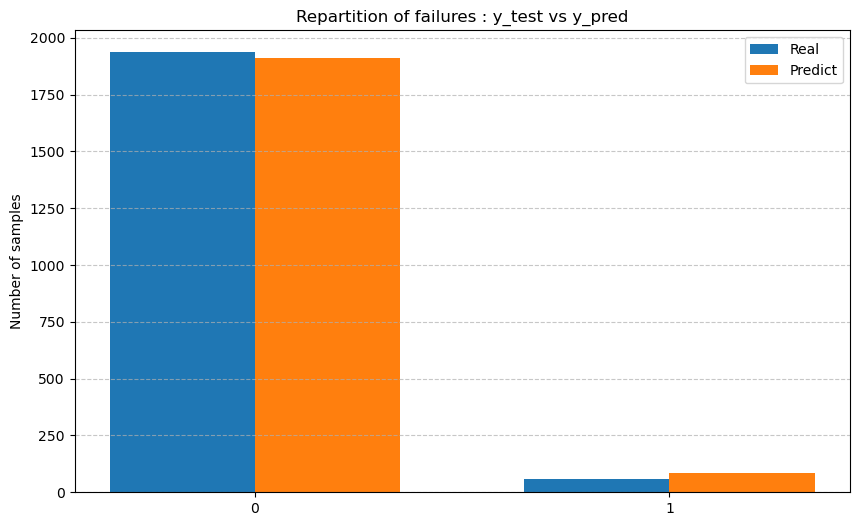

In [13]:
true_counts = pd.Series(y_test_target).value_counts().sort_index()
pred_counts = pd.Series(y_pred_target).value_counts().sort_index()

classes = sorted(set(y_test_target) | set(y_pred_target)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of failures : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Thanks to y_test.csv which contains real values, we compare our results with the actual value to evaluate our final model:

In [344]:
y_pred = {
    'Target': y_pred_target,
    'Failure Type': np.array([0]*len(y_pred_target))
}

In [346]:
rus = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)

pipe_logreg = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', LogisticRegression(
        max_iter=1000, 
        random_state=42)) #parametres a checker avec les filles gridsearch
])

pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', SVC(
    kernel='rbf', 
    C=1, 
    gamma='scale', 
    probability=True, 
    random_state=42))
])

pipe_nn = Pipeline([
    ('scaler', StandardScaler()),
    ('rus', rus),
    ('smote', smote),
    ('clf', MLPClassifier(hidden_layer_sizes=(50,50),
                                max_iter=1000,
                                learning_rate_init=0.01,
                                early_stopping=True,
                                n_iter_no_change=20,
                                validation_fraction=0.1,
                                random_state=42))
])


bag_logreg = BaggingClassifier(
    estimator=pipe_logreg,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_svm = BaggingClassifier(
    estimator=pipe_svm,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_nn = BaggingClassifier(
    estimator=pipe_nn,
    n_estimators=10,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)


voting_clf = VotingClassifier(
    estimators=[
        ('bag_logreg', bag_logreg),
        ('bag_svm', bag_svm),
        ('bag_nn', bag_nn)
    ],
    voting='soft',     # "soft" uses probabilities which is more appropriate due to multi classes here
    n_jobs=-1
)

voting_clf.fit(X_train, y_train_failure_type)


VotingClassifier(estimators=[('bag_logreg',
                              BaggingClassifier(estimator=Pipeline(steps=[('scaler',
                                                                           StandardScaler()),
                                                                          ('rus',
                                                                           RandomUnderSampler(random_state=42)),
                                                                          ('smote',
                                                                           SMOTE(random_state=42)),
                                                                          ('clf',
                                                                           LogisticRegression(max_iter=1000,
                                                                                              random_state=42))]),
                                                max_samples=0.8, n_jobs=-1,
                                                random_state=42)),
                             ('bag_svm',
                              BaggingClassifier(estimator=Pipeline(steps=...
                              BaggingClassifier(estimator=Pipeline(steps=[('scaler',
                                                                           StandardScaler()),
                                                                          ('rus',
                                                                           RandomUnderSampler(random_state=42)),
                                                                          ('smote',
                                                                           SMOTE(random_state=42)),
                                                                          ('clf',
                                                                           MLPClassifier(early_stopping=True,
                                                                                         hidden_layer_sizes=(50,
                                                                                                             50),
                                                                                         learning_rate_init=0.01,
                                                                                         max_iter=1000,
                                                                                         n_iter_no_change=20,
                                                                                         random_state=42))]),
                                                max_samples=0.8, n_jobs=-1,
                                                random_state=42))],
                 n_jobs=-1, voting='soft')

In [329]:
X_test.iloc[2]

Type                       -1.0
Air_temperature_K         301.7
Process_temperature_K     309.5
Rotational_speed_rpm     1298.0
Torque_Nm                  65.5
Tool_wear_min             229.0
Name: 2, dtype: float64

In [331]:
y_test.iloc[2]

Target          1
Failure Type    0
Name: 2, dtype: int64

In [348]:
for index in range(len(y_pred_target)) :
    if y_pred_target[index]==1:
    #prediction
        failure_type_pred = voting_clf.predict(X_test.iloc[index].to_frame().T) #because index starts at 1 in dataset  but index from 0
        y_pred['Failure Type'][index] = failure_type_pred[0]

    else:
        y_pred['Failure Type'][index] = 1
        

## Repartition visualization

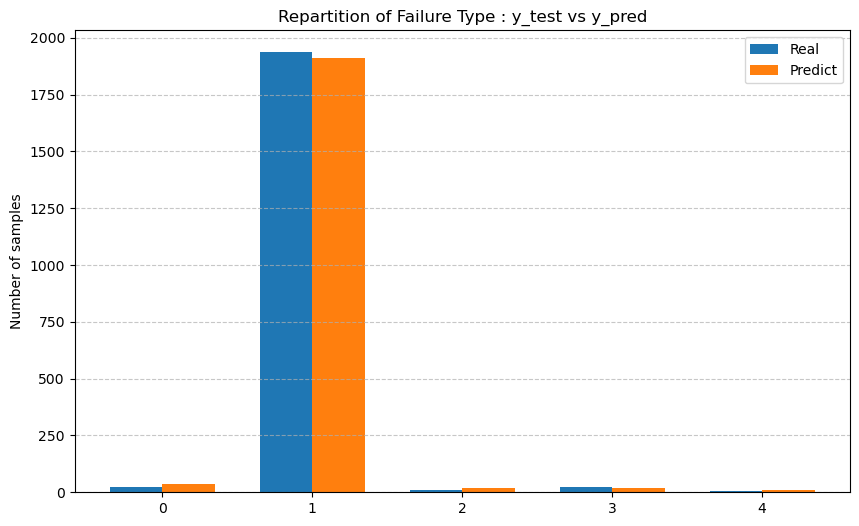

In [351]:
y_pred_failure_type = y_pred['Failure Type']

true_counts = pd.Series(y_test_failure_type).value_counts().sort_index()
pred_counts = pd.Series(y_pred_failure_type).value_counts().sort_index()

classes = sorted(set(y_test_failure_type) | set(y_pred_failure_type)) 

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - width/2, [true_counts.get(c,0) for c in classes], width, label='Real')
ax.bar(x + width/2, [pred_counts.get(c,0) for c in classes], width, label='Predict')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of samples')
ax.set_title('Repartition of Failure Type : y_test vs y_pred')
ax.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [353]:
y_pred = pd.DataFrame.from_dict(y_pred)

#### Final evaluation

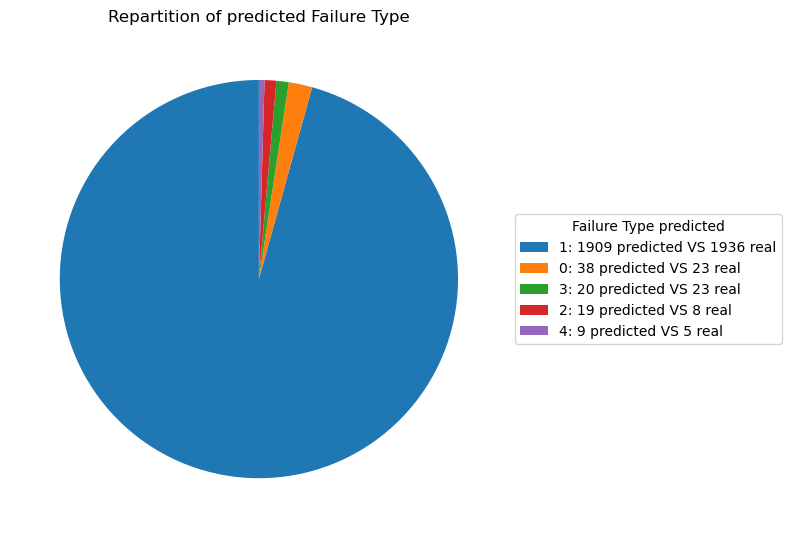

In [380]:
failure_counts = y_test["Failure Type"].value_counts()
failure_counts_pred = y_pred['Failure Type'].value_counts()

plt.figure(figsize=(8, 8))
pie_result = plt.pie(
    failure_counts_pred,
    labels=None,
    startangle=90
)
wedges = pie_result[0]
labels_with_pct = [
    f"{label}: {count_pred} predicted VS {count} real" for label, count_pred, count in zip(failure_counts.index, failure_counts_pred, failure_counts)
]
plt.legend(
    wedges,
    labels_with_pct,
    title="Failure Type predicted",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)
plt.title("Repartition of predicted Failure Type")
plt.tight_layout()
plt.show()

In [385]:
print('Metrics for Target')
acc = accuracy_score(y_test_target, y_pred_target)
f1 = f1_score(y_test_target, y_pred_target)
recall = recall_score(y_test_target, y_pred_target)
print(f"Recall: {recall:.4f} \nAccuracy: {acc:.4f} \nF1-score: {f1:.4f}")
print('confusion matrix')
cm = confusion_matrix(y_test_target, y_pred_target)
print(cm)

print('\nMetrics for Failure Type')
acc = accuracy_score(y_test_failure_type, y_pred_failure_type)
f1 = f1_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
rcl_multiclass = recall_score(y_test_failure_type, y_pred_failure_type, average="macro", zero_division=0)
blcd_acc = balanced_accuracy_score(y_test_failure_type, y_pred_failure_type)
print(f"Recall: {rcl_multiclass:.4f} \nAccuracy: {acc:.4f} \nBalanced Accuracy: {blcd_acc:.4f} \nF1-score: {f1:.4f}")
print('confusion matrix')
cm = confusion_matrix(y_test_failure_type, y_pred_failure_type)
print(cm)

Metrics for Target
Recall: 0.8136 
Accuracy: 0.9754 
F1-score: 0.6621
confusion matrix
[[1898   38]
 [  11   48]]

Metrics for Failure Type
Recall: 0.7415 
Accuracy: 0.9744 
Balanced Accuracy: 0.7415 
F1-score: 0.6256
confusion matrix
[[  21    0    2    0    0]
 [  17 1898   11    2    8]
 [   0    1    7    0    0]
 [   0    6    0   17    0]
 [   0    4    0    0    1]]


##### Analysis 

As expected in the notebook of comparison between results for Failure Type, there are more predicted failures as expected that for with a Stacking Classifier.